# What is CLTV (Customer Life Time Value)?
- Customer lifetime value (CLTV), represents the total amount of money a customer is expected to spend in your business, or on your products, during their lifetime.

- Focusing on CLTV helps you design an efficient strategy with concise budget planning. However, some customers bring your business  more value than the others. That’s why it’s crucial to know which ones you should focus on first and invest in.

- With CLTV calculation, you can take a picture of today, but with CLTV prediction, you make time projections such as 3 months, 1 year.

**BG/NBD (Beta Geometric / Negative Binomial Distribution) Model**
will model each customer’s purchase behaviours’ distribution and will predict the expected number of transactions for each customer. It is also known as “Buy Till You Die” Model.

**BG/NBD model, models 2 processes as**

- **Transaction Process (Buy)**
- During the customer is alive, the number of will have made by the customer, will be distributed poison by transaction rate parameter
- During the customer is alive, they will be purchasing around their own transaction rate
- Transaction rates will change for each customer and they will be distributed gamma (r,α)

- **Dropout Process (Till You Die)**
- Each customer has their own dropout rate by p probability
- The customer will be a dropout by p probability
- Dropout rates will change for each customer and they will be distributed beta (a,b) for the mass

**Gamma-Gamma Submodel** will model the expected average profit distribution and will predict the expected average profit for each customer.

# Business Problem
- Our goal is to identify the customers who can generate the most revenue in certain time periods (1 week, 1 month, 3 months, 6 months, 1 year).

# Data Story

- The dataset, Online Retail II, contains the sales of a UK-based online retail store between 01/12/2009 and 09/12/2011.

Variables

- **InvoiceNo:** Invoice number. The unique number of each transaction, that is, the invoice. Aborted operation if it starts with C.

- **StockCode:** Product code. Unique number for each product.

- **Description:** Product name

- **Quantity:** Number of products. It expresses how many of the products on the invoices have been sold.

- **InvoiceDate:** Invoice date and time.

- **UnitPrice:** Product price (in GBP)

- **CustomerID:** Unique customer number

- **Country:** Country name. Country where the customer lives.

# Road Map

-  Data Preparation
-  Expected Number of Transaction with BG-NBD Model
-  Expected Average Profit with Gamma-Gamma Model
-  Calculation of CLTV with BG-NBD and Gamma-Gamma Model
-  Creation of Segments According to CLTV


In [1]:
!pip install lifetimes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 4.1 MB/s eta 0:00:00


In [2]:
# import Required Libraries

import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt

import matplotlib.pyplot as plt
import plotly.express as px
import warnings

from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

warnings.simplefilter(action="ignore")

In [3]:
# Adjusting Row Column Settings
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: '%.4f' % x)

In [4]:
# Loading the Data Set
df1 = pd.read_excel('/kaggle/input/uci-online-retail-ii-data-set/online_retail_II.xlsx', sheet_name='Year 2009-2010')
df2 = pd.read_excel('/kaggle/input/uci-online-retail-ii-data-set/online_retail_II.xlsx', sheet_name='Year 2010-2011')

In [5]:
# The two data sets were merged.

df_ = pd.concat([df1, df2], ignore_index=True)

In [6]:
# A copy of the data was made to avoid reloading the data from the beginning.

df = df_.copy()

In [7]:
# Preliminary examination of the data set

def check_df(dataframe, head=5):
    print('##################### Shape #####################')
    print(dataframe.shape)
    print('##################### Types #####################')
    print(dataframe.dtypes)
    print('##################### Head #####################')
    print(dataframe.head(head))
    print('##################### Tail #####################')
    print(dataframe.tail(head))
    print('##################### NA #####################')
    print(dataframe.isnull().sum())
    print('##################### Quantiles #####################')
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)

##################### Shape #####################
(1067371, 8)
##################### Types #####################
Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object
##################### Head #####################
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00 6.9500   13085.0000  United Kingdom  
1 2009-12-01 07:45:00 6.7500   13085.0000  

In [8]:
# Examination of numerical and categorical variables

def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    Returns the names of categorical, numeric and categorical but cardinal variables in the data set.
    Note Categorical variables include categorical variables with numeric appearance.
    Parameters
    ------
         dataframe: dataframe
                Dataframe to get variable names
        cat_th: int, optional
                class threshold for numeric but categorical variables
        car_th: int, optinal
                class threshold for categorical but cardinal variables
    Returns
    ------
        cat_cols: list
                Categorical variable list
        num_cols: list
                Numeric variable list
        cat_but_car: list
                List of cardinal variables with categorical view
    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))
    Notes
    ------
        cat_cols + num_cols + cat_but_car = total number of variables
        num_but_cat is inside cat_cols.
        The sum of the 3 return lists equals the total number of variables: cat_cols + num_cols + cat_but_car = number of variables
    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == 'O']
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != 'O']
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == 'O']
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != 'O']
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f'Observations: {dataframe.shape[0]}')
    print(f'Variables: {dataframe.shape[1]}')
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car, num_but_cat

cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df)

Observations: 1067371
Variables: 8
cat_cols: 0
num_cols: 4
cat_but_car: 4
num_but_cat: 0


In [9]:
# We selected the sales with a sales number greater than zero from df and reassigned it to the df variable. 
#The reason for doing this is to remove the purchase returns from the data set.

df = df[(df['Quantity'] > 0)]

In [10]:
# To eliminate observations with negative values due to returns, we selected observations greater than zero.

df = df[df["Price"] > 0]

In [11]:
# From the observations in the dataset, we selected the observations that do not contain the C expression.

df = df[df["Invoice"].astype(str).str.contains("C")==False]

In [12]:
# We removed empty observations from the data set.

df.dropna(inplace=True)

In [13]:
df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [14]:
# We have eliminated the outliers.

def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [15]:
replace_with_thresholds(df, "Quantity")
replace_with_thresholds(df, "Price")

In [16]:
# Checking the last status of outliers.

def check_outlier(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    if dataframe[(dataframe[variable] > up_limit) | (dataframe[variable] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [17]:
check_outlier(df, "Quantity")

False

In [18]:
check_outlier(df, "Price")

False

In [19]:
# Creation of TotalPrice

df["TotalPrice"] = df["Quantity"] * df["Price"]

In [20]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12.0000,2009-12-01 07:45:00,6.9500,13085.0000,United Kingdom,83.4000
1,489434,79323P,PINK CHERRY LIGHTS,12.0000,2009-12-01 07:45:00,6.7500,13085.0000,United Kingdom,81.0000
2,489434,79323W,WHITE CHERRY LIGHTS,12.0000,2009-12-01 07:45:00,6.7500,13085.0000,United Kingdom,81.0000
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48.0000,2009-12-01 07:45:00,2.1000,13085.0000,United Kingdom,100.8000
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24.0000,2009-12-01 07:45:00,1.2500,13085.0000,United Kingdom,30.0000


In [21]:
# Present Date (date of analysis)

today_date = dt.datetime(2011, 12, 11)

In [22]:
today_date

datetime.datetime(2011, 12, 11, 0, 0)

# Preparation of Lifetime Data Structure

- **recency:** Time since last purchase. Weekly (user specific)
- **T:** Age of the customer. Weekly (how long before the date of analysis was the first purchase)
- **frequency:** Total number of repeat purchases (frequency>1)
- **monetary:** Average revenue per purchase

In [23]:
df["InvoiceDate"].max()

Timestamp('2011-12-09 12:50:00')

In [24]:
df["InvoiceDate"].min()

Timestamp('2009-12-01 07:45:00')

In [25]:
cltv_df = df.groupby('Customer ID').agg(
    {'InvoiceDate': [lambda InvoiceDate: (InvoiceDate.max() - InvoiceDate.min()).days,
                     lambda InvoiceDate: (today_date - InvoiceDate.min()).days],
     'Invoice': lambda Invoice: Invoice.nunique(),
     'TotalPrice': lambda TotalPrice: TotalPrice.sum()})

In [26]:
cltv_df.head()

InvoiceDate             Invoice TotalPrice
             <lambda_0> <lambda_1> <lambda>   <lambda>
Customer ID                                           
12346.0000          400        726       12   704.1000
12347.0000          402        405        8  5633.3200
12348.0000          362        439        5  1991.8600
12349.0000          570        590        4  3786.5000
12350.0000            0        311        1   331.3400

In [27]:
cltv_df.columns = cltv_df.columns.droplevel(0)

In [28]:
cltv_df.head()

,<lambda_0>,<lambda_1>,<lambda>,<lambda>
Customer ID,,,,
12346.0000,400,726,12,704.1000
12347.0000,402,405,8,5633.3200
12348.0000,362,439,5,1991.8600
12349.0000,570,590,4,3786.5000
12350.0000,0,311,1,331.3400


In [29]:
# Change the columns name

cltv_df.columns = ['recency', 'T', 'frequency', 'monetary']

In [30]:
cltv_df.head()

,recency,T,frequency,monetary
Customer ID,,,,
12346.0000,400,726,12,704.1000
12347.0000,402,405,8,5633.3200
12348.0000,362,439,5,1991.8600
12349.0000,570,590,4,3786.5000
12350.0000,0,311,1,331.3400


- We will need to convert the types of these values so that we can do the calculations and apply the model.
- **Recency** = weekly
- **Monetary** = Average
- **T** = weekly

In [31]:
# We calculated the average value for each customer.

cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]

In [32]:
cltv_df.head()

,recency,T,frequency,monetary
Customer ID,,,,
12346.0000,400,726,12,58.6750
12347.0000,402,405,8,704.1650
12348.0000,362,439,5,398.3720
12349.0000,570,590,4,946.6250
12350.0000,0,311,1,331.3400


In [33]:
# We chose frequency to be greater than 1.

cltv_df = cltv_df[(cltv_df['frequency'] > 1)]

In [34]:
cltv_df.head(20)

,recency,T,frequency,monetary
Customer ID,,,,
12346.0000,400,726,12,58.6750
12347.0000,402,405,8,704.1650
12348.0000,362,439,5,398.3720
12349.0000,570,590,4,946.6250
12352.0000,356,393,10,209.8940
12353.0000,204,409,2,203.3800
12355.0000,353,568,2,473.8050
12356.0000,401,425,6,1062.2800
12357.0000,355,389,3,5824.8667


In [35]:
# We converted the recency value to weekly.

cltv_df["recency"] = cltv_df["recency"] / 7

In [36]:
cltv_df.head()

,recency,T,frequency,monetary
Customer ID,,,,
12346.0000,57.1429,726,12,58.6750
12347.0000,57.4286,405,8,704.1650
12348.0000,51.7143,439,5,398.3720
12349.0000,81.4286,590,4,946.6250
12352.0000,50.8571,393,10,209.8940


In [37]:
# We translated the age of the customer on a weekly basis.

cltv_df["T"] = cltv_df["T"] / 7

In [38]:
cltv_df.head()

,recency,T,frequency,monetary
Customer ID,,,,
12346.0000,57.1429,103.7143,12,58.6750
12347.0000,57.4286,57.8571,8,704.1650
12348.0000,51.7143,62.7143,5,398.3720
12349.0000,81.4286,84.2857,4,946.6250
12352.0000,50.8571,56.1429,10,209.8940


# Establishing BG-NBD Model

In [39]:
# Created model object

bgf = BetaGeoFitter(penalizer_coef=0.001)

In [40]:
# Model fitting

bgf.fit(cltv_df['frequency'],
        cltv_df['recency'],
        cltv_df['T'])

<lifetimes.BetaGeoFitter: fitted with 4255 subjects, a: 0.24, alpha: 11.24, b: 3.06, r: 1.71>

# Who are the top 10 customers we expect to buy from in 1 week?

In [41]:
bgf.conditional_expected_number_of_purchases_up_to_time(1,
                                                        cltv_df['frequency'],
                                                        cltv_df['recency'],
                                                        cltv_df['T']).sort_values(ascending=False).head(10)

Customer ID
14911.0000   3.4132
12748.0000   2.8943
17841.0000   1.8170
15311.0000   1.7910
13089.0000   1.7474
14606.0000   1.6575
14156.0000   1.3320
14646.0000   1.3041
18102.0000   1.2524
13694.0000   1.2373
dtype: float64

In [42]:
# The short name if uses with "predict" (this stuation is only for bg/nbd model)

bgf.predict(1,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sort_values(ascending=False).head(10)

Customer ID
14911.0000   3.4132
12748.0000   2.8943
17841.0000   1.8170
15311.0000   1.7910
13089.0000   1.7474
14606.0000   1.6575
14156.0000   1.3320
14646.0000   1.3041
18102.0000   1.2524
13694.0000   1.2373
dtype: float64

In [43]:
# add to cltv_df (1 week)

cltv_df["expected_purc_1_week"] = bgf.predict(1,
                                              cltv_df['frequency'],
                                              cltv_df['recency'],
                                              cltv_df['T'])

In [44]:
cltv_df.head()

,recency,T,frequency,monetary,expected_purc_1_week
Customer ID,,,,,
12346.0000,57.1429,103.7143,12,58.6750,0.0055
12347.0000,57.4286,57.8571,8,704.1650,0.1369
12348.0000,51.7143,62.7143,5,398.3720,0.0825
12349.0000,81.4286,84.2857,4,946.6250,0.0571
12352.0000,50.8571,56.1429,10,209.8940,0.1651


# Total expected sales in 1 week.

In [45]:
bgf.predict(1,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sum()

432.2920505975047

# Who are the top 10 customers we expect to buy from in 1 month?

In [46]:
bgf.predict(4,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sort_values(ascending=False).head(10)

Customer ID
14911.0000   13.6120
12748.0000   11.5425
17841.0000    7.2465
15311.0000    7.1425
13089.0000    6.9689
14606.0000    6.6104
14156.0000    5.3121
14646.0000    5.2010
18102.0000    4.9945
13694.0000    4.9344
dtype: float64

In [47]:
# add to cltv_df (1 month)

cltv_df["expected_purc_1_month"] = bgf.predict(4,
                                               cltv_df['frequency'],
                                               cltv_df['recency'],
                                               cltv_df['T'])

In [48]:
cltv_df.head()

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month
Customer ID,,,,,,
12346.0000,57.1429,103.7143,12,58.6750,0.0055,0.0218
12347.0000,57.4286,57.8571,8,704.1650,0.1369,0.5451
12348.0000,51.7143,62.7143,5,398.3720,0.0825,0.3286
12349.0000,81.4286,84.2857,4,946.6250,0.0571,0.2276
12352.0000,50.8571,56.1429,10,209.8940,0.1651,0.6572


# In 1 Months, What is the Expected Number of Sales for the Whole Company?

In [49]:
bgf.predict(4,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sum()

1719.3880847906894

# In 3 Months, What is the Expected Number of Sales for the Whole Company?

In [50]:
bgf.predict(4 * 3,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sum()

5087.5477910417485

In [51]:
# add to cltv_df (3 months)

cltv_df["expected_purc_3_month"] = bgf.predict(4 * 3,
                                               cltv_df['frequency'],
                                               cltv_df['recency'],
                                               cltv_df['T'])

In [52]:
cltv_df.head()

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month
Customer ID,,,,,,,
12346.0000,57.1429,103.7143,12,58.6750,0.0055,0.0218,0.0648
12347.0000,57.4286,57.8571,8,704.1650,0.1369,0.5451,1.6158
12348.0000,51.7143,62.7143,5,398.3720,0.0825,0.3286,0.9748
12349.0000,81.4286,84.2857,4,946.6250,0.0571,0.2276,0.6769
12352.0000,50.8571,56.1429,10,209.8940,0.1651,0.6572,1.9474


# In 6 Months, What is the Expected Number of Sales for the Whole Company?

In [53]:
# add to cltv_df (6 months)

cltv_df["expected_purc_6_month"] = bgf.predict(4 * 6,
                                               cltv_df['frequency'],
                                               cltv_df['recency'],
                                               cltv_df['T'])

In [54]:
cltv_df.head()

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_purc_6_month
Customer ID,,,,,,,,
12346.0000,57.1429,103.7143,12,58.6750,0.0055,0.0218,0.0648,0.1283
12347.0000,57.4286,57.8571,8,704.1650,0.1369,0.5451,1.6158,3.1783
12348.0000,51.7143,62.7143,5,398.3720,0.0825,0.3286,0.9748,1.9199
12349.0000,81.4286,84.2857,4,946.6250,0.0571,0.2276,0.6769,1.3374
12352.0000,50.8571,56.1429,10,209.8940,0.1651,0.6572,1.9474,3.8288


In [55]:
bgf.predict(4 * 6,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sum()

9992.985580748738

# In 9 Months, What is the Expected Number of Sales for the Whole Company?

In [56]:
# add to cltv_df (9 months)

cltv_df["expected_purc_9_month"] = bgf.predict(4 * 9,
                                               cltv_df['frequency'],
                                               cltv_df['recency'],
                                               cltv_df['T'])

In [57]:
cltv_df.head()

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_purc_6_month,expected_purc_9_month
Customer ID,,,,,,,,,
12346.0000,57.1429,103.7143,12,58.6750,0.0055,0.0218,0.0648,0.1283,0.1905
12347.0000,57.4286,57.8571,8,704.1650,0.1369,0.5451,1.6158,3.1783,4.6957
12348.0000,51.7143,62.7143,5,398.3720,0.0825,0.3286,0.9748,1.9199,2.8394
12349.0000,81.4286,84.2857,4,946.6250,0.0571,0.2276,0.6769,1.3374,1.9834
12352.0000,50.8571,56.1429,10,209.8940,0.1651,0.6572,1.9474,3.8288,5.6544


In [58]:
bgf.predict(4 * 9,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sum()

14753.376706219991

# In 1 Year, What is the Expected Number of Sales for the Whole Company?

In [59]:
# add to cltv_df (1 year)

cltv_df["expected_purc_1_year"] = bgf.predict(4 * 12,
                                               cltv_df['frequency'],
                                               cltv_df['recency'],
                                               cltv_df['T'])

In [60]:
cltv_df.head()

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_purc_6_month,expected_purc_9_month,expected_purc_1_year
Customer ID,,,,,,,,,,
12346.0000,57.1429,103.7143,12,58.6750,0.0055,0.0218,0.0648,0.1283,0.1905,0.2516
12347.0000,57.4286,57.8571,8,704.1650,0.1369,0.5451,1.6158,3.1783,4.6957,6.1740
12348.0000,51.7143,62.7143,5,398.3720,0.0825,0.3286,0.9748,1.9199,2.8394,3.7367
12349.0000,81.4286,84.2857,4,946.6250,0.0571,0.2276,0.6769,1.3374,1.9834,2.6165
12352.0000,50.8571,56.1429,10,209.8940,0.1651,0.6572,1.9474,3.8288,5.6544,7.4320


In [61]:
bgf.predict(4 * 12,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sum()

19392.127946847417

# Evaluation of Forecast Results

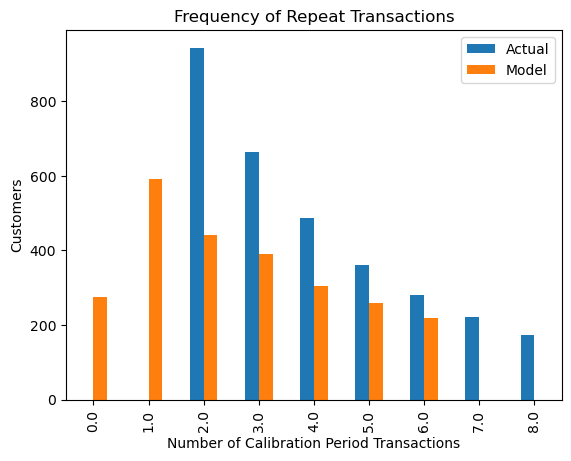

In [62]:
plot_period_transactions(bgf)
plt.show(block=True)

# Establishing the GAMMA-GAMMA Model

In [63]:
# Created model object

ggf = GammaGammaFitter(penalizer_coef=0.01)

In [64]:
# Model fitting

ggf.fit(cltv_df['frequency'], cltv_df['monetary'])

<lifetimes.GammaGammaFitter: fitted with 4255 subjects, p: 3.80, q: 0.34, v: 3.74>

In [65]:
# Expected profit for the first 10 customers

ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                        cltv_df['monetary']).head(10)

Customer ID
12346.0000     59.8502
12347.0000    720.2151
12348.0000    413.4323
12349.0000    990.4172
12352.0000    213.9718
12353.0000    224.6973
12355.0000    520.7427
12356.0000   1094.4767
12357.0000   6182.8322
12358.0000    799.0927
dtype: float64

In [66]:
# Expected profit for the top 10 customers
ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                        cltv_df['monetary']).sort_values(ascending=False).head(10)

Customer ID
12357.0000   6182.8322
12590.0000   5035.2460
12415.0000   5034.5651
14091.0000   4997.1846
14088.0000   4029.9276
18102.0000   3731.1484
12753.0000   3678.2984
12409.0000   3430.9834
15749.0000   3430.9068
14646.0000   3365.3009
dtype: float64

In [67]:
# add to cltv_df

cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                             cltv_df['monetary'])

In [68]:
cltv_df.head()

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_purc_6_month,expected_purc_9_month,expected_purc_1_year,expected_average_profit
Customer ID,,,,,,,,,,,
12346.0000,57.1429,103.7143,12,58.6750,0.0055,0.0218,0.0648,0.1283,0.1905,0.2516,59.8502
12347.0000,57.4286,57.8571,8,704.1650,0.1369,0.5451,1.6158,3.1783,4.6957,6.1740,720.2151
12348.0000,51.7143,62.7143,5,398.3720,0.0825,0.3286,0.9748,1.9199,2.8394,3.7367,413.4323
12349.0000,81.4286,84.2857,4,946.6250,0.0571,0.2276,0.6769,1.3374,1.9834,2.6165,990.4172
12352.0000,50.8571,56.1429,10,209.8940,0.1651,0.6572,1.9474,3.8288,5.6544,7.4320,213.9718


In [69]:
cltv_df.sort_values("expected_average_profit", ascending=False).head(10)

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_purc_6_month,expected_purc_9_month,expected_purc_1_year,expected_average_profit
Customer ID,,,,,,,,,,,
12357.0000,50.7143,55.5714,3,5824.8667,0.0660,0.2629,0.7793,1.5331,2.2654,2.9791,6182.8322
12590.0000,0.0000,30.2857,2,4597.6125,0.0106,0.0419,0.1236,0.2413,0.3545,0.4638,5035.2460
12415.0000,71.8571,75.4286,28,5003.3098,0.3332,1.3277,3.9433,7.7765,11.5139,15.1670,5034.5651
14091.0000,6.2857,99.8571,2,4562.8450,0.0006,0.0024,0.0071,0.0140,0.0208,0.0274,4997.1846
14088.0000,58.5714,60.2857,16,3986.0988,0.2424,0.9650,2.8607,5.6281,8.3161,10.9356,4029.9276
18102.0000,105.4286,105.5714,145,3726.6687,1.2524,4.9945,14.8687,29.4144,43.6707,57.6655,3731.1484
12753.0000,48.4286,51.8571,6,3571.5650,0.1168,0.4646,1.3760,2.7036,3.9905,5.2426,3678.2984
12409.0000,69.4286,80.8571,7,3345.6129,0.0873,0.3478,1.0340,2.0417,3.0260,3.9898,3430.9834
15749.0000,13.8571,47.5714,3,3231.7133,0.0223,0.0889,0.2631,0.5166,0.7621,1.0009,3430.9068


# Calculation of CLTV with BG-NBD and GG model.

In [70]:
cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency'],
                                   cltv_df['T'],
                                   cltv_df['monetary'],
                                   time=3,  # 3 months
                                   freq="W",  # T's frequency information.
                                   discount_rate=0.01)

In [71]:
cltv.head()

Customer ID
12346.0000      4.1290
12347.0000   1237.4448
12348.0000    428.6136
12349.0000    713.1659
12352.0000    443.0763
Name: clv, dtype: float64

In [72]:
cltv = cltv.reset_index()

In [73]:
cltv.head()

,Customer ID,clv
0,12346.0000,4.1290
1,12347.0000,1237.4448
2,12348.0000,428.6136
3,12349.0000,713.1659
4,12352.0000,443.0763


In [74]:
cltv_df.head()

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_purc_6_month,expected_purc_9_month,expected_purc_1_year,expected_average_profit
Customer ID,,,,,,,,,,,
12346.0000,57.1429,103.7143,12,58.6750,0.0055,0.0218,0.0648,0.1283,0.1905,0.2516,59.8502
12347.0000,57.4286,57.8571,8,704.1650,0.1369,0.5451,1.6158,3.1783,4.6957,6.1740,720.2151
12348.0000,51.7143,62.7143,5,398.3720,0.0825,0.3286,0.9748,1.9199,2.8394,3.7367,413.4323
12349.0000,81.4286,84.2857,4,946.6250,0.0571,0.2276,0.6769,1.3374,1.9834,2.6165,990.4172
12352.0000,50.8571,56.1429,10,209.8940,0.1651,0.6572,1.9474,3.8288,5.6544,7.4320,213.9718


In [75]:
# We merged cltv_df dataset with cltv dataset merge.

cltv_final = cltv_df.merge(cltv, on="Customer ID", how="left")

In [76]:
cltv_final.head()

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_purc_6_month,expected_purc_9_month,expected_purc_1_year,expected_average_profit,clv
0,12346.0000,57.1429,103.7143,12,58.6750,0.0055,0.0218,0.0648,0.1283,0.1905,0.2516,59.8502,4.1290
1,12347.0000,57.4286,57.8571,8,704.1650,0.1369,0.5451,1.6158,3.1783,4.6957,6.1740,720.2151,1237.4448
2,12348.0000,51.7143,62.7143,5,398.3720,0.0825,0.3286,0.9748,1.9199,2.8394,3.7367,413.4323,428.6136
3,12349.0000,81.4286,84.2857,4,946.6250,0.0571,0.2276,0.6769,1.3374,1.9834,2.6165,990.4172,713.1659
4,12352.0000,50.8571,56.1429,10,209.8940,0.1651,0.6572,1.9474,3.8288,5.6544,7.4320,213.9718,443.0763


In [77]:
cltv_final.sort_values(by="clv", ascending=False).head(10)

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_purc_6_month,expected_purc_9_month,expected_purc_1_year,expected_average_profit,clv
4139,18102.0000,105.4286,105.5714,145,3726.6687,1.2524,4.9945,14.8687,29.4144,43.6707,57.6655,3731.1484,59022.9051
1652,14646.0000,105.0000,105.4286,151,3361.4186,1.3041,5.2010,15.4834,30.6300,45.4749,60.0471,3365.3009,55436.1993
1290,14156.0000,104.0000,105.5714,156,1903.5948,1.3320,5.3121,15.8141,31.2845,46.4471,61.3315,1905.7332,32063.4678
1840,14911.0000,105.2857,105.5714,398,709.3988,3.4132,13.6120,40.5224,80.1624,119.0121,157.1477,709.7169,30597.3079
3682,17450.0000,61.2857,62.7143,51,3334.3318,0.7029,2.7988,8.2981,16.3284,24.1309,31.7358,3345.7601,29523.8465
1247,14096.0000,13.8571,14.5714,17,3163.4965,0.7071,2.7932,8.1358,15.6849,22.8184,29.6339,3196.2592,27600.9279
51,12415.0000,71.8571,75.4286,28,5003.3098,0.3332,1.3277,3.9433,7.7765,11.5139,15.1670,5034.5651,21115.8852
949,13694.0000,104.4286,105.1429,143,1338.7443,1.2373,4.9344,14.6894,29.0587,43.1412,56.9647,1340.3929,20947.8726
3728,17511.0000,104.8571,105.4286,60,2924.4313,0.5257,2.0967,6.2421,12.3491,18.3351,24.2115,2932.9545,19477.9350
3114,16684.0000,104.0000,104.7143,55,2513.8125,0.4858,1.9373,5.7672,11.4090,16.9384,22.3663,2521.8167,15473.3025


- **Notice:** This is how the customer_lifetime_value function names the data frame it returns (clv).
- **Information :** In the BG/NBD model, the monetary value of a customer with no churn or dropout may increase as the recency value increases.

# Creation of Segments According to CLTV

In [78]:
cltv_final["segment"] = pd.qcut(cltv_final["clv"], 4, labels=["D", "C", "B", "A"])

In [79]:
cltv_final.sort_values(by="clv", ascending=False).head(50)

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_purc_6_month,expected_purc_9_month,expected_purc_1_year,expected_average_profit,clv,segment
4139,18102.0000,105.4286,105.5714,145,3726.6687,1.2524,4.9945,14.8687,29.4144,43.6707,57.6655,3731.1484,59022.9051,A
1652,14646.0000,105.0000,105.4286,151,3361.4186,1.3041,5.2010,15.4834,30.6300,45.4749,60.0471,3365.3009,55436.1993,A
1290,14156.0000,104.0000,105.5714,156,1903.5948,1.3320,5.3121,15.8141,31.2845,46.4471,61.3315,1905.7332,32063.4678,A
1840,14911.0000,105.2857,105.5714,398,709.3988,3.4132,13.6120,40.5224,80.1624,119.0121,157.1477,709.7169,30597.3079,A
3682,17450.0000,61.2857,62.7143,51,3334.3318,0.7029,2.7988,8.2981,16.3284,24.1309,31.7358,3345.7601,29523.8465,A
1247,14096.0000,13.8571,14.5714,17,3163.4965,0.7071,2.7932,8.1358,15.6849,22.8184,29.6339,3196.2592,27600.9279,A
51,12415.0000,71.8571,75.4286,28,5003.3098,0.3332,1.3277,3.9433,7.7765,11.5139,15.1670,5034.5651,21115.8852,A
949,13694.0000,104.4286,105.1429,143,1338.7443,1.2373,4.9344,14.6894,29.0587,43.1412,56.9647,1340.3929,20947.8726,A
3728,17511.0000,104.8571,105.4286,60,2924.4313,0.5257,2.0967,6.2421,12.3491,18.3351,24.2115,2932.9545,19477.9350,A
3114,16684.0000,104.0000,104.7143,55,2513.8125,0.4858,1.9373,5.7672,11.4090,16.9384,22.3663,2521.8167,15473.3025,A


In [80]:
cltv_final.groupby("segment").agg(
    {"count", "mean", "sum"})

Customer ID                     recency                        T  \
               mean count           sum    mean count        sum    mean   
segment                                                                    
D        15402.8553  1064 16388638.0000 27.9911  1064 29782.5714 81.7560   
C        15496.4229  1064 16488194.0000 59.6950  1064 63515.4286 75.8716   
B        15268.1637  1063 16230058.0000 63.0556  1063 67028.1429 71.1111   
A        15071.8759  1064 16036476.0000 64.7883  1064 68934.7143 68.8907   

                         frequency              monetary                    \
        count        sum      mean count    sum     mean count         sum   
segment                                                                      
D        1064 86988.4286    3.9718  1064   4226 254.2035  1064 270472.5456   
C        1064 80727.4286    4.5461  1064   4837 262.2236  1064 279005.8920   
B        1063 75591.1429    7.2700  1063   7728 351.2340  1063 373361.7842   
A        1064 73299.7143   17.4389  1064  18555 593.7813  1064 631783.3082   

        expected_purc_1_week                expected_purc_1_month        \
                        mean count      sum                  mean count   
segment                                                                   
D                     0.0149  1064  15.8712                0.0594  1064   
C                     0.0621  1064  66.1026                0.2473  1064   
B                     0.1059  1063 112.5209                0.4210  1063   
A                     0.2235  1064 237.7973                0.8886  1064   

                 expected_purc_3_month                 expected_purc_6_month  \
             sum                  mean count       sum                  mean   
segment                                                                        
D        63.2318                0.1765  1064  187.7889                0.3481   
C       263.1201                0.7329  1064  779.8551                1.4423   
B       447.5706                1.2460  1063 1324.4516                2.4473   
A       945.4656                2.6273  1064 2795.4522                5.1565   

                        expected_purc_9_month                  \
        count       sum                  mean count       sum   
segment                                                         
D        1064  370.3869                0.5156  1064  548.5476   
C        1064 1534.5610                2.1321  1064 2268.5576   
B        1063 2601.4774                3.6128  1063 3840.4426   
A        1064 5486.5603                7.6089  1064 8095.8290   

        expected_purc_1_year                  expected_average_profit        \
                        mean count        sum                    mean count   
segment                                                                       
D                     0.6793  1064   722.8256                272.4850  1064   
C                     2.8053  1064  2984.8480                278.3532  1064   
B                     4.7483  1063  5047.3987                366.6028  1063   
A                     9.9972  1064 10637.0556                611.1615  1064   

                          clv                     
                sum      mean count          sum  
segment                                           
D       289924.0158   32.2787  1064   34344.4913  
C       296167.7980  179.0048  1064  190461.0755  
B       389698.7496  408.3702  1063  434097.5045  
A       650275.8538 1642.1570  1064 1747255.0718

In [81]:
# cltv_final2 = create_cltv_p(df)

In [82]:
# cltv_final2.to_csv("cltv_prediction.csv")

In [83]:
cltv_final.head()

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_purc_6_month,expected_purc_9_month,expected_purc_1_year,expected_average_profit,clv,segment
0,12346.0000,57.1429,103.7143,12,58.6750,0.0055,0.0218,0.0648,0.1283,0.1905,0.2516,59.8502,4.1290,D
1,12347.0000,57.4286,57.8571,8,704.1650,0.1369,0.5451,1.6158,3.1783,4.6957,6.1740,720.2151,1237.4448,A
2,12348.0000,51.7143,62.7143,5,398.3720,0.0825,0.3286,0.9748,1.9199,2.8394,3.7367,413.4323,428.6136,B
3,12349.0000,81.4286,84.2857,4,946.6250,0.0571,0.2276,0.6769,1.3374,1.9834,2.6165,990.4172,713.1659,A
4,12352.0000,50.8571,56.1429,10,209.8940,0.1651,0.6572,1.9474,3.8288,5.6544,7.4320,213.9718,443.0763,B


In [84]:
grouped_data = cltv_final.groupby(["Customer ID"]).agg({
    "expected_purc_1_week": "sum",
    "expected_purc_1_month": "sum",
    "expected_purc_3_month": "sum",
    "expected_purc_6_month": "sum",
    "expected_purc_9_month": "sum",
    "expected_purc_1_year": "sum"
}).head(10)

In [85]:
grouped_data

,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_purc_6_month,expected_purc_9_month,expected_purc_1_year
Customer ID,,,,,,
12346.0000,0.0055,0.0218,0.0648,0.1283,0.1905,0.2516
12347.0000,0.1369,0.5451,1.6158,3.1783,4.6957,6.1740
12348.0000,0.0825,0.3286,0.9748,1.9199,2.8394,3.7367
12349.0000,0.0571,0.2276,0.6769,1.3374,1.9834,2.6165
12352.0000,0.1651,0.6572,1.9474,3.8288,5.6544,7.4320
12353.0000,0.0369,0.1471,0.4364,0.8594,1.2708,1.6722
12355.0000,0.0318,0.1269,0.3775,0.7460,1.1063,1.4595
12356.0000,0.1026,0.4087,1.2122,2.3862,3.5276,4.6407
12357.0000,0.0660,0.2629,0.7793,1.5331,2.2654,2.9791


# Some Graphics

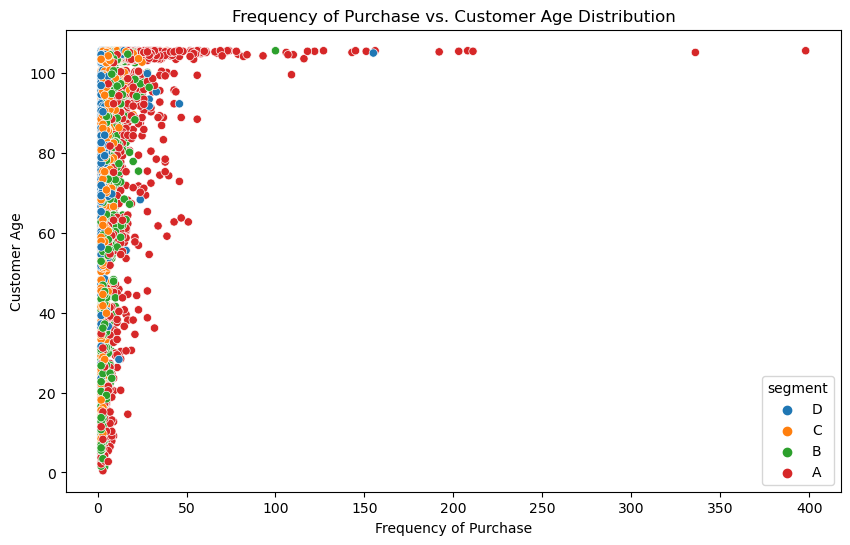

In [86]:
# Distribution of Purchase Frequency and Customer Age

plt.figure(figsize=(10, 6))
sns.scatterplot(data=cltv_final, x='frequency', y='T', hue='segment')
plt.xlabel('Frequency of Purchase')
plt.ylabel('Customer Age')
plt.title('Frequency of Purchase vs. Customer Age Distribution')
plt.show()

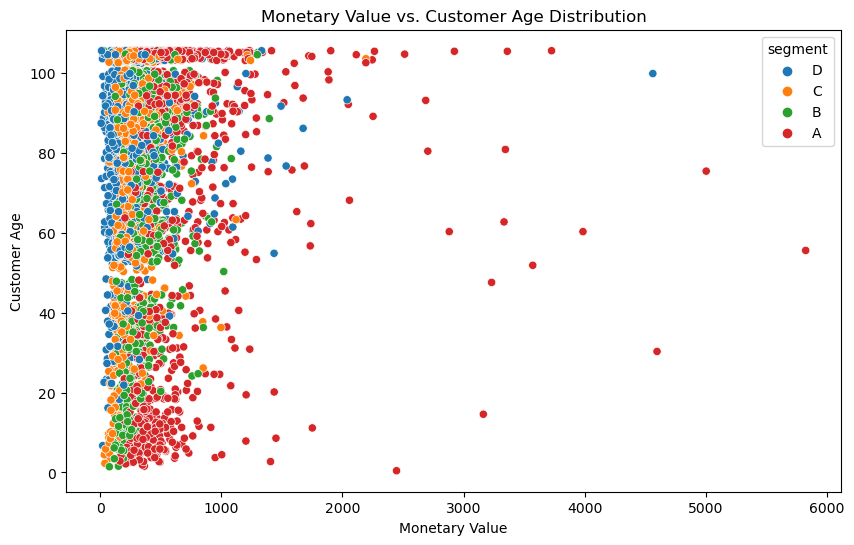

In [87]:
# Distribution of Purchase Amount and Customer Age

plt.figure(figsize=(10, 6))
sns.scatterplot(data=cltv_final, x='monetary', y='T', hue='segment')
plt.xlabel('Monetary Value')
plt.ylabel('Customer Age')
plt.title('Monetary Value vs. Customer Age Distribution')
plt.show()

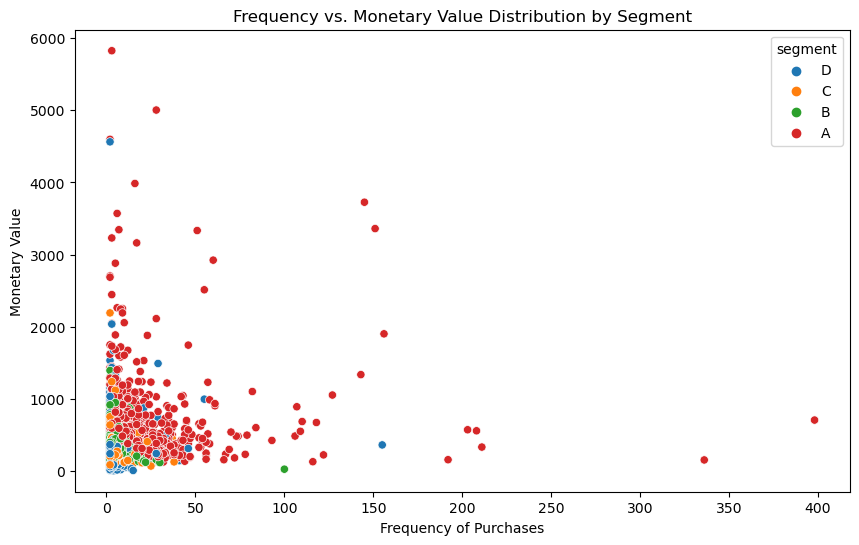

In [88]:
# Purchase Frequency and Purchase Amount Distribution by Segment

plt.figure(figsize=(10, 6))
sns.scatterplot(data=cltv_final, x='frequency', y='monetary', hue='segment')
plt.xlabel('Frequency of Purchases')
plt.ylabel('Monetary Value')
plt.title('Frequency vs. Monetary Value Distribution by Segment')
plt.show()


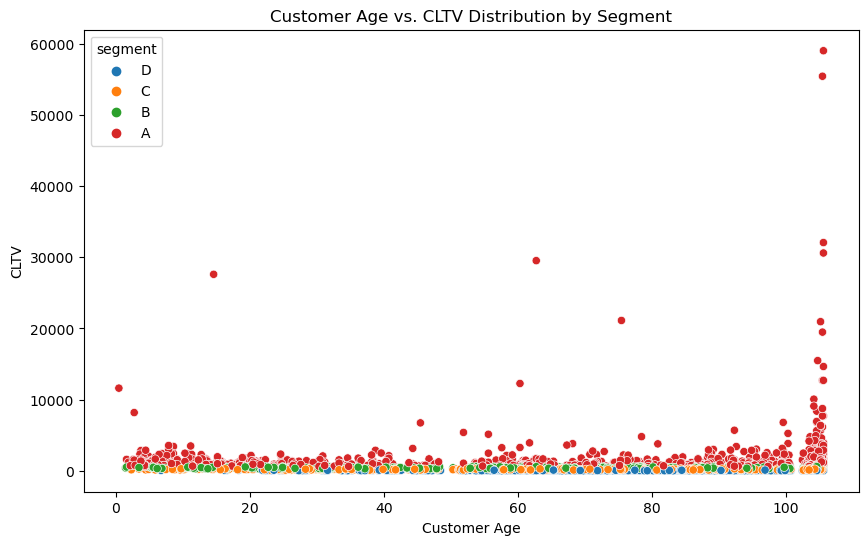

In [89]:
# Customer Age and CLTV Distribution

plt.figure(figsize=(10, 6))
sns.scatterplot(data=cltv_final, x='T', y='clv', hue='segment')
plt.xlabel('Customer Age')
plt.ylabel('CLTV')
plt.title('Customer Age vs. CLTV Distribution by Segment')
plt.show()

In [90]:
cltv_final = pd.merge(cltv_final, df[['Customer ID', 'Country']], on='Customer ID', how='left')

In [91]:
cltv_final.head()

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_purc_6_month,expected_purc_9_month,expected_purc_1_year,expected_average_profit,clv,segment,Country
0,12346.0000,57.1429,103.7143,12,58.6750,0.0055,0.0218,0.0648,0.1283,0.1905,0.2516,59.8502,4.1290,D,United Kingdom
1,12346.0000,57.1429,103.7143,12,58.6750,0.0055,0.0218,0.0648,0.1283,0.1905,0.2516,59.8502,4.1290,D,United Kingdom
2,12346.0000,57.1429,103.7143,12,58.6750,0.0055,0.0218,0.0648,0.1283,0.1905,0.2516,59.8502,4.1290,D,United Kingdom
3,12346.0000,57.1429,103.7143,12,58.6750,0.0055,0.0218,0.0648,0.1283,0.1905,0.2516,59.8502,4.1290,D,United Kingdom
4,12346.0000,57.1429,103.7143,12,58.6750,0.0055,0.0218,0.0648,0.1283,0.1905,0.2516,59.8502,4.1290,D,United Kingdom


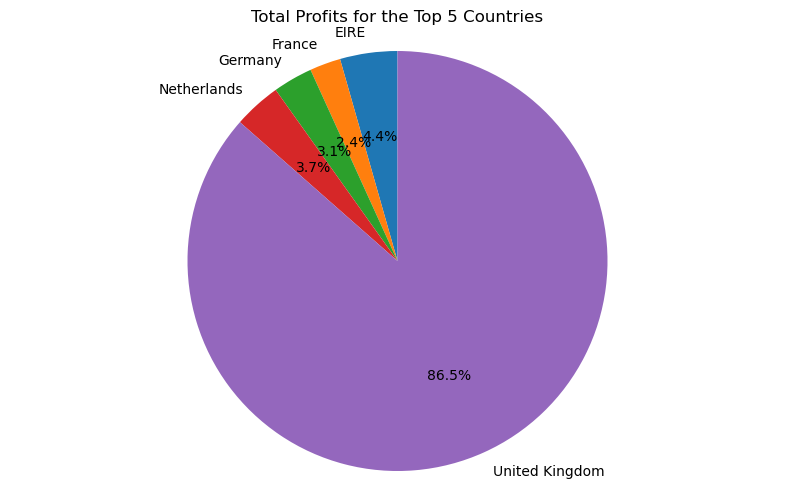

In [92]:
# Total Profits for the Top 5 Countries

top_5_countries = cltv_final['Country'].value_counts().nlargest(5).index.tolist()
top_5_countries_data = cltv_final[cltv_final['Country'].isin(top_5_countries)]

profit_by_country = top_5_countries_data.groupby('Country')['expected_average_profit'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.pie(profit_by_country['expected_average_profit'], labels=profit_by_country['Country'], autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Total Profits for the Top 5 Countries')
plt.show()


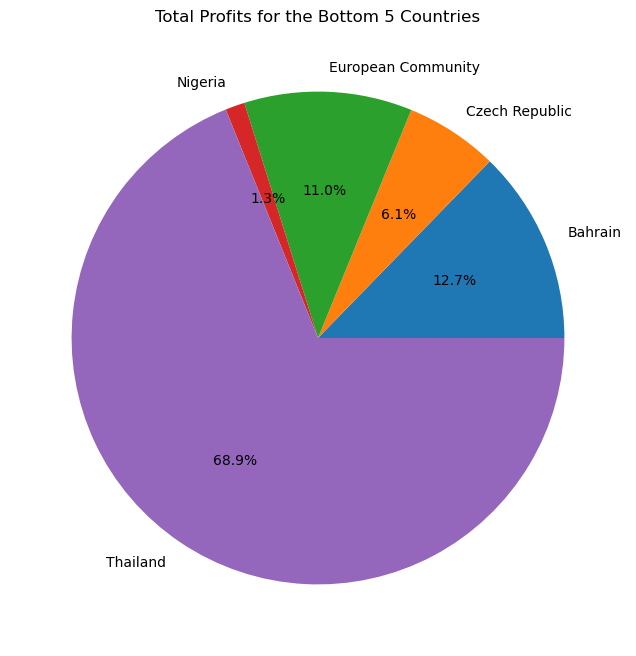

In [93]:
# Total Profits for the Bottom 5 Countries

bottom_5_countries = cltv_final['Country'].value_counts().nsmallest(5).index.tolist()
bottom_5_countries_data = cltv_final[cltv_final['Country'].isin(bottom_5_countries)]

profit_by_country = bottom_5_countries_data.groupby('Country')['expected_average_profit'].sum().reset_index()

plt.figure(figsize=(8, 8))
plt.pie(profit_by_country['expected_average_profit'], labels=profit_by_country['Country'], autopct='%1.1f%%')
plt.title('Total Profits for the Bottom 5 Countries')
plt.show()
